## Agricultural Pests Image Classification using various transfer learning techniques

### A -  Project initialization and necessary library importation

In [1]:
import sys
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import preprocessing                                                               
from sklearn.model_selection import train_test_split                                             
import shutil
import glob,os,random
import cv2
import keras
from keras import layers,models
from keras.optimizers import SGD
from keras.utils import load_img,img_to_array,array_to_img,plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D,Flatten,MaxPooling2D,Dense,GlobalAveragePooling2D
from keras.models import Sequential,load_model
import tensorflow as tf
from keras.applications import ResNet50
from keras.applications.resnet_v2 import ResNet152V2
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.optimizers import Adam
from keras.layers import Dense, Flatten, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping,ModelCheckpoint
import warnings
warnings.filterwarnings("ignore")


### B - Loading image directories

In [2]:
# Set the path to the directory containing training data
train_path = "AI_Assignment/train_data"

# List the contents (files and subdirectories) of the specified directory
# and store the list of item names in the 'train_path' variable
os.listdir(train_path)

['slug',
 'snail',
 'bees',
 'ants',
 'catterpillar',
 'wasp',
 'moth',
 'grasshopper',
 'weevil',
 'beetle',
 'earthworms',
 'earwig']

In [3]:
# Set the path to the directory containing test data
test_path = "AI_Assignment/test_data"

# List the contents (files and subdirectories) of the specified directory
# and store the list of item names in the 'test_path' variable
os.listdir(test_path)

['slug',
 'snail',
 'bees',
 'ants',
 'catterpillar',
 'wasp',
 'moth',
 'grasshopper',
 'weevil',
 'beetle',
 'earthworms',
 'earwig']

### C - Checking the number of images in test and train dataset - Data Exploration

In [4]:
# 'train_pest_images' will store the paths to all JPEG image files found in the specified directories
# The 'os.path.join(parent_path, "*/*.jpg")' creates a file path pattern that matches
# all JPEG files within subdirectories under 'train_path'
train_pest_images = glob.glob(os.path.join(train_path,"*/*.jpg"))

# Print the number of pest images found
print(f"There are {len(train_pest_images)} available in the training dataset" )

There are 4383 available in the training dataset


In [5]:
# 'test_pest_images' will store the paths to all JPEG image files found in the specified directories
# The 'os.path.join(parent_path, "*/*.jpg")' creates a file path pattern that matches
# all JPEG files within subdirectories under 'test_path'
test_pest_images = glob.glob(os.path.join(test_path,"*/*.jpg"))

# Print the number of pest images found
print(f"There are {len(test_pest_images)} available in the testing dataset" )

There are 1102 available in the testing dataset


### D - Preview the Dataset  - Data Exploration

Find Sample Images below:


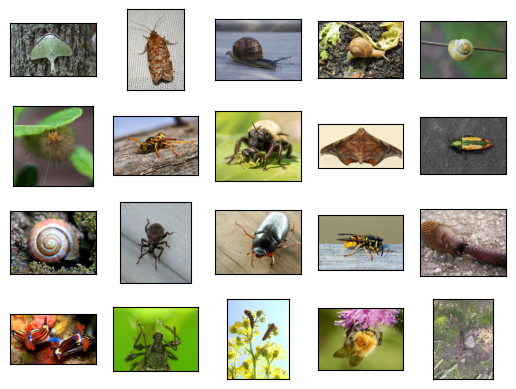

In [6]:
print("Find Sample Images below:")
print("====================================================================================================================")

# Select and process a random sample of 15 image file paths from the 'train_pest_images' list
for index,path in enumerate(random.sample(train_pest_images,20)):
    image = load_img(path)
    image = img_to_array(image,dtype = np.uint8)
    plt.subplot(4,5,index + 1)
    plt.imshow(image.squeeze())
    plt.rcParams["figure.figsize"] = (15,15)
    plt.grid(visible = None)
    plt.xticks([])
    plt.yticks([])

### E - Image Preprocessing - Data Augumentation

In [7]:
# Create an ImageDataGenerator for training data with various augmentation options
train_data_generator = ImageDataGenerator(
    rescale=1./255,  # Scale pixel values to [0, 1]
    rotation_range=30,  # Randomly rotate images within the range of [-30, 30] degrees
    shear_range=0.15,  # Apply shear transformation with a shear intensity of 0.15
    zoom_range=0.15,  # Randomly zoom in/out by up to 15%
    width_shift_range=0.1,  # Randomly shift the width by up to 10%
    height_shift_range=0.1,  # Randomly shift the height by up to 10%
 #   horizontal_flip=True,  # Flip images horizontally
 #   vertical_flip=True,  # Flip images vertically
    validation_split=0.2,  # Split 20% of the data for validation
    fill_mode='nearest'  # Fill empty areas after transformations using nearest neighbors
)

# Create an ImageDataGenerator for test data with simple rescaling
test_data_generator = ImageDataGenerator(
    rescale=1./255  # Scale pixel values to [0, 1]
)

### F - Training and Validation Dataset creation

In [8]:
# Define the desired input shape for the images
input_shape = (256, 256)
# Define the batch size for training/testing
batch_size = 64


# Create Training Dataset
train_dataset = train_data_generator.flow_from_directory(
    train_path,         # Directory containing the training data
    target_size=input_shape,  # Desired input image dimensions (e.g., (256, 256))
    batch_size=batch_size,    # Number of images per batch during training (e.g., 64)
    class_mode="categorical", # Type of labels ("categorical" for one-hot encoded labels)
    subset="training",        # Subset of the data to use (in this case, "training" subset)
    seed=123                 # Seed for reproducibility
)


# Create Validation Dataset
validation_dataset = train_data_generator.flow_from_directory(
    train_path,           # Directory containing the validation or test data
    target_size=input_shape,  # Desired input image dimensions (e.g., (256, 256))
    batch_size=batch_size,    # Number of images per batch during validation/testing (e.g., 64)
    class_mode="categorical", # Type of labels ("categorical" for one-hot encoded labels)
    subset="validation",      # Subset of the data to use (in this case, "validation" subset)
    shuffle=False,            # Do not shuffle the data (important for validation/testing)
    seed=123                  # Seed for reproducibility
)



Found 3518 images belonging to 12 classes.
Found 873 images belonging to 12 classes.


### G - Store the different labels the Pests

In [9]:
# Get the dictionary of class indices from the training dataset
pest_class_dict = train_dataset.class_indices

# Extract the pest names (pest_class) from the dictionary using a list comprehension
# 'pest' corresponds to the class name, and 'index' corresponds to the class index
pest_class = [pest for pest, index in pest_class_dict.items()]

print("==================================================")
print("The Labels have been extracted successfully")

The Labels have been extracted successfully


### H - CNN Model without Transfer Learning

In [10]:

# Define input shape, batch size, number of classes and learning rate
input_shape = (256, 256, 3)
batch_size = 64
num_classes = 12
learning_rate = 0.001 


# Create the model
model = models.Sequential()

# Layer 1: Convolutional + MaxPooling + BatchNormalization
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))  # Downsample and reduce spatial dimensions
model.add(layers.BatchNormalization())  # Normalize outputs for stable training

# Layer 2: Convolutional + MaxPooling + BatchNormalization
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

# Layer 3: Convolutional + MaxPooling + BatchNormalization
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

# Flatten feature maps and add fully connected layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))  # Fully connected layer
model.add(layers.Dropout(0.5))  # Dropout for regularization
model.add(layers.Dense(num_classes, activation='softmax'))  # Output layer


In [11]:
# Compile the model with a specific learning rate
model.compile(
    optimizer=keras.optimizers.legacy.Adam(learning_rate=learning_rate),  # Use the Adam optimizer with the specified learning rate
    loss='categorical_crossentropy',  # Specify the loss function
    metrics=['accuracy']  # Specify evaluation metrics
)

# Print a summary of the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 64)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 127, 127, 64)      256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 128)       0         
 g2D)                                                            
                                                        

In [12]:
# Train the model using callbacks
history = model.fit(
    train_dataset, # Training dataset generator
    epochs=10, # Number of training epochs
    validation_data=validation_dataset, # Validation dataset generator
    callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=4, verbose=2), # Perform early stopping based on validation accuracy
    ModelCheckpoint(filepath='./norm_model.h5', monitor='val_accuracy', verbose=0, save_best_only=True)
    ]
)

Epoch 1/10
55/55 [==============================] - 216s 4s/step - loss: 47.7742 - accuracy: 0.1245 - val_loss: 31.8344 - val_accuracy: 0.0905
Epoch 2/10
55/55 [==============================] - 214s 4s/step - loss: 27.6208 - accuracy: 0.1669 - val_loss: 91.6821 - val_accuracy: 0.0584
Epoch 3/10
55/55 [==============================] - 214s 4s/step - loss: 18.1302 - accuracy: 0.1529 - val_loss: 67.9323 - val_accuracy: 0.0710
Epoch 4/10
55/55 [==============================] - 214s 4s/step - loss: 11.9327 - accuracy: 0.1379 - val_loss: 14.9813 - val_accuracy: 0.0825
Epoch 5/10
55/55 [==============================] - 221s 4s/step - loss: 5.2447 - accuracy: 0.1259 - val_loss: 11.3172 - val_accuracy: 0.0928
Epoch 6/10
55/55 [==============================] - 204s 4s/step - loss: 3.8306 - accuracy: 0.1236 - val_loss: 24.7564 - val_accuracy: 0.0504
Epoch 7/10
55/55 [==============================] - 205s 4s/step - loss: 3.2341 - accuracy: 0.1154 - val_loss: 8.2935 - val_accuracy: 0.1249
Epo

### I - Evaluate CNN Model without Transfer Learning

In [13]:
# Create function to plot evaluation graphs as this will be done repeatedly in this study
def plot_graph(history, type):
    plt.figure(figsize=(7, 5)) 
    if type == 'accuracy':
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.show()
    else:
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.show()

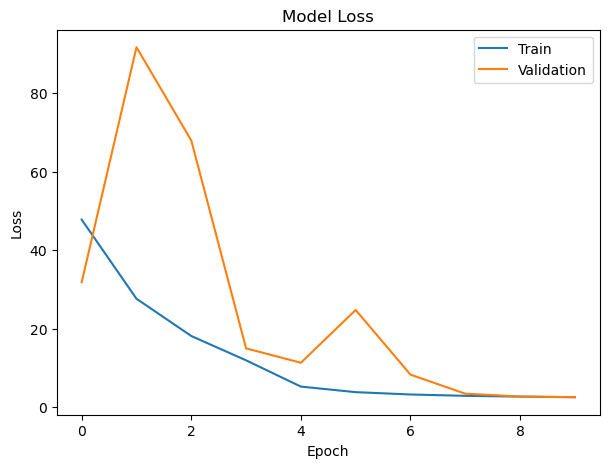

In [14]:
# Plot Model Loss graph
plot_graph(history,'loss')

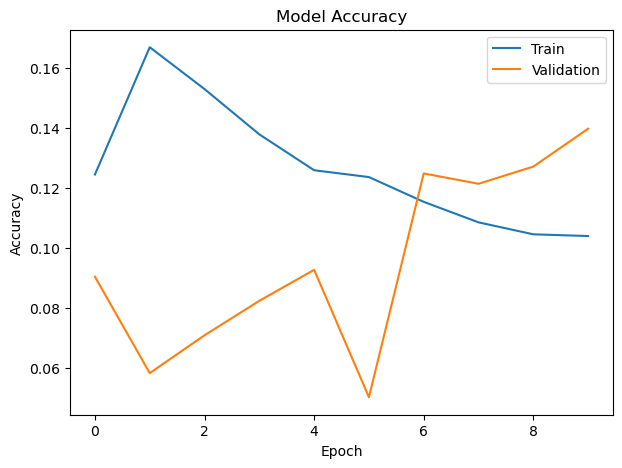

In [15]:
# Plot Model accuracy graph
plot_graph(history,'accuracy')

In [16]:
# Create Function to print accuracy and loss of model as it will be utilized repeatedly
def evalaution_metrics(name,model):
    model_ = load_model(model)
    loss,accuracy = model_.evaluate(validation_dataset,verbose=0)
    print("=======================")
    print(f"The accuracy of the {name} model is {accuracy:.4f}")
    print("=======================")
    print(f"The loss of the {name} model is {loss:.4f}")

In [17]:
# Evaluate model
evalaution_metrics('CNN(No Transfer Learning)','norm_model.h5' )

The accuracy of the CNN(No Transfer Learning) model is 0.1375
The loss of the CNN(No Transfer Learning) model is 2.5528


### J - CNN Model with Transfer Learning - ResNet50

In [18]:
# Create a function to handle model computations as simlar architecture will be used to test different transfer learning architectures

# Create model architecture
def create_model_arch(tran_learn_arch):
    for layer in tran_learn_arch.layers:
        layer.trainable = False

    # Add custom layer on top of the pre-trained model
    # Flatten the output of the pre-trained model's convolutional layers
    x = Flatten()(tran_learn_arch.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.25)(x)

    # Add another fully connected dense layer with 1024 units and ReLU activation
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Add the final output layer for your specific task
    model_layers = Dense(num_classes, activation='softmax')(x)

    # Create the final custom model
    # The input is the same as the input of the pre-trained model, and the output is the newly defined output layer
    model = Model(inputs=tran_learn_arch.input, outputs=model_layers)
    return model


# Create a function to compile the model and modify the learning rate
def compile_model(model,learning_rate):
    model.compile(
    optimizer=keras.optimizers.legacy.Adam(learning_rate=learning_rate),  # Use the Adam optimizer with the specified learning rate
    loss='categorical_crossentropy',  # Specify the loss function
    metrics=['accuracy']  # Specify evaluation metrics
    )

    # Print a summary of the model architecture
    model.summary()
    return model
    

In [19]:
# Initialize a ResNet50 model for transfer learning with specific settings:
# - Input images are expected to have dimensions of 256x256 pixels and 3 color channels (RGB).
# - Global average pooling ('avg') will be applied to the output of the convolutional layers.
# - The model's weights will be initialized using pre-trained weights from the ImageNet dataset.
# - The original classification layers will be excluded, leaving only the convolutional base.
model = ResNet50(input_shape=(256, 256, 3), pooling='avg', weights='imagenet', include_top=False)

In [20]:
# Using model functions created earlier:

model = create_model_arch(model)
model = compile_model(model,0.001)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 64, 64, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 64, 64, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 64, 64, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 32, 32, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 32, 32, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 32, 32, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 16, 16, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 16, 16, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 16, 16, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 16, 16, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 16, 16, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 16, 16, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 16, 16, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 16, 16, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 16, 16, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 16, 16, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 8, 8, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 8, 8, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 8, 8, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 8, 8, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [21]:
# Train the model using callbacks
history = model.fit(
    train_dataset, # Training dataset generator
    epochs=10, # Number of training epochs
    validation_data=validation_dataset, # Validation dataset generator
    callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=4, verbose=2), # Perform early stopping based on validation accuracy
    ModelCheckpoint(filepath='./resnet50_model.h5', monitor='val_accuracy', verbose=0, save_best_only=True)
    ]
)

Epoch 1/10
55/55 [==============================] - 155s 3s/step - loss: 2.5515 - accuracy: 0.0958 - val_loss: 2.4805 - val_accuracy: 0.0962
Epoch 2/10
55/55 [==============================] - 154s 3s/step - loss: 2.4819 - accuracy: 0.0887 - val_loss: 2.4747 - val_accuracy: 0.0905
Epoch 3/10
55/55 [==============================] - 155s 3s/step - loss: 2.4786 - accuracy: 0.0998 - val_loss: 2.4755 - val_accuracy: 0.1271
Epoch 4/10
55/55 [==============================] - 154s 3s/step - loss: 2.4722 - accuracy: 0.1117 - val_loss: 2.4646 - val_accuracy: 0.1283
Epoch 5/10
55/55 [==============================] - 155s 3s/step - loss: 2.4616 - accuracy: 0.1128 - val_loss: 2.4548 - val_accuracy: 0.1363
Epoch 6/10
55/55 [==============================] - 156s 3s/step - loss: 2.4636 - accuracy: 0.1151 - val_loss: 2.4511 - val_accuracy: 0.1340
Epoch 7/10
55/55 [==============================] - 156s 3s/step - loss: 2.4576 - accuracy: 0.1228 - val_loss: 2.4458 - val_accuracy: 0.1386
Epoch 8/10
55

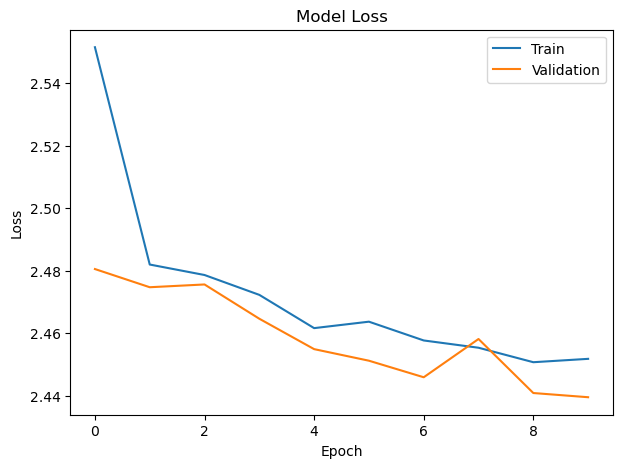

In [22]:
# Plot Model Loss graph
plot_graph(history,'loss')

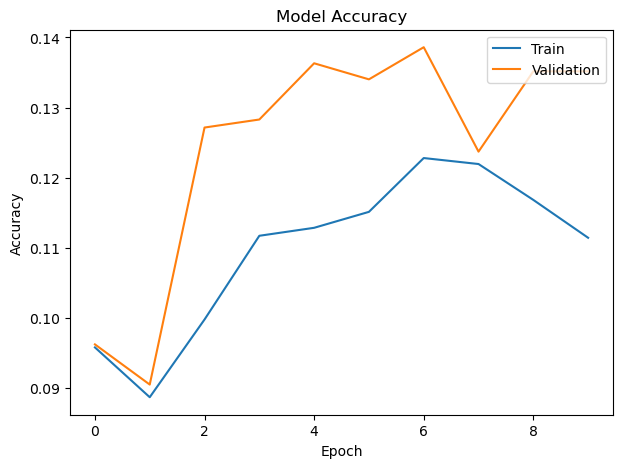

In [23]:
# Plot Model accuracy graph
plot_graph(history,'accuracy')

In [24]:
# Evaluate model
evalaution_metrics('CNN(ResNet50 Transfer Learning)','resnet50_model.h5' )

The accuracy of the CNN(ResNet50 Transfer Learning) model is 0.1340
The loss of the CNN(ResNet50 Transfer Learning) model is 2.4485


### J - CNN Model with Transfer Learning - ResNet152V2


In [25]:
# Initialize a ResNet152V2 model for transfer learning with specific settings:
model = ResNet152V2(input_shape=(256,256, 3),pooling='avg',weights = 'imagenet',include_top=False)

In [26]:
# Using model functions created earlier:

model = create_model_arch(model)
model = compile_model(model,0.001)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 130, 130, 64)         0         ['conv1_conv[0][0]']          
                                                                                            

 tchNormalization)                                                                                
                                                                                                  
 conv2_block3_preact_relu (  (None, 64, 64, 256)          0         ['conv2_block3_preact_bn[0][0]
 Activation)                                                        ']                            
                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 64, 64, 64)           16384     ['conv2_block3_preact_relu[0][
 D)                                                                 0]']                          
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 64, 64, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
          

 conv3_block2_1_relu (Activ  (None, 32, 32, 128)          0         ['conv3_block2_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block2_2_pad (ZeroPa  (None, 34, 34, 128)          0         ['conv3_block2_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv3_block2_2_conv (Conv2  (None, 32, 32, 128)          147456    ['conv3_block2_2_pad[0][0]']  
 D)                                                                                               
                                                                                                  
 conv3_block2_2_bn (BatchNo  (None, 32, 32, 128)          512       ['conv3_block2_2_conv[0][0]'] 
 rmalizati

                                                                                                  
 conv3_block4_out (Add)      (None, 32, 32, 512)          0         ['conv3_block3_out[0][0]',    
                                                                     'conv3_block4_3_conv[0][0]'] 
                                                                                                  
 conv3_block5_preact_bn (Ba  (None, 32, 32, 512)          2048      ['conv3_block4_out[0][0]']    
 tchNormalization)                                                                                
                                                                                                  
 conv3_block5_preact_relu (  (None, 32, 32, 512)          0         ['conv3_block5_preact_bn[0][0]
 Activation)                                                        ']                            
                                                                                                  
 conv3_blo

 ation)                                                                                           
                                                                                                  
 conv3_block7_2_pad (ZeroPa  (None, 34, 34, 128)          0         ['conv3_block7_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv3_block7_2_conv (Conv2  (None, 32, 32, 128)          147456    ['conv3_block7_2_pad[0][0]']  
 D)                                                                                               
                                                                                                  
 conv3_block7_2_bn (BatchNo  (None, 32, 32, 128)          512       ['conv3_block7_2_conv[0][0]'] 
 rmalization)                                                                                     
          

 conv4_block1_0_conv (Conv2  (None, 16, 16, 1024)         525312    ['conv4_block1_preact_relu[0][
 D)                                                                 0]']                          
                                                                                                  
 conv4_block1_3_conv (Conv2  (None, 16, 16, 1024)         263168    ['conv4_block1_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_out (Add)      (None, 16, 16, 1024)         0         ['conv4_block1_0_conv[0][0]', 
                                                                     'conv4_block1_3_conv[0][0]'] 
                                                                                                  
 conv4_block2_preact_bn (Ba  (None, 16, 16, 1024)         4096      ['conv4_block1_out[0][0]']    
 tchNormal

                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 16, 16, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block4_1_relu (Activ  (None, 16, 16, 256)          0         ['conv4_block4_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block4_2_pad (ZeroPa  (None, 18, 18, 256)          0         ['conv4_block4_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv4_blo

 ation)                                                                                           
                                                                                                  
 conv4_block6_3_conv (Conv2  (None, 16, 16, 1024)         263168    ['conv4_block6_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block6_out (Add)      (None, 16, 16, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_conv[0][0]'] 
                                                                                                  
 conv4_block7_preact_bn (Ba  (None, 16, 16, 1024)         4096      ['conv4_block6_out[0][0]']    
 tchNormalization)                                                                                
          

 conv4_block9_1_bn (BatchNo  (None, 16, 16, 256)          1024      ['conv4_block9_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block9_1_relu (Activ  (None, 16, 16, 256)          0         ['conv4_block9_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block9_2_pad (ZeroPa  (None, 18, 18, 256)          0         ['conv4_block9_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv4_block9_2_conv (Conv2  (None, 16, 16, 256)          589824    ['conv4_block9_2_pad[0][0]']  
 D)       

                                                                                                  
 conv4_block11_3_conv (Conv  (None, 16, 16, 1024)         263168    ['conv4_block11_2_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block11_out (Add)     (None, 16, 16, 1024)         0         ['conv4_block10_out[0][0]',   
                                                                     'conv4_block11_3_conv[0][0]']
                                                                                                  
 conv4_block12_preact_bn (B  (None, 16, 16, 1024)         4096      ['conv4_block11_out[0][0]']   
 atchNormalization)                                                                               
                                                                                                  
 conv4_blo

 ormalization)                                                                                    
                                                                                                  
 conv4_block14_1_relu (Acti  (None, 16, 16, 256)          0         ['conv4_block14_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block14_2_pad (ZeroP  (None, 18, 18, 256)          0         ['conv4_block14_1_relu[0][0]']
 adding2D)                                                                                        
                                                                                                  
 conv4_block14_2_conv (Conv  (None, 16, 16, 256)          589824    ['conv4_block14_2_pad[0][0]'] 
 2D)                                                                                              
          

 conv4_block16_3_conv (Conv  (None, 16, 16, 1024)         263168    ['conv4_block16_2_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block16_out (Add)     (None, 16, 16, 1024)         0         ['conv4_block15_out[0][0]',   
                                                                     'conv4_block16_3_conv[0][0]']
                                                                                                  
 conv4_block17_preact_bn (B  (None, 16, 16, 1024)         4096      ['conv4_block16_out[0][0]']   
 atchNormalization)                                                                               
                                                                                                  
 conv4_block17_preact_relu   (None, 16, 16, 1024)         0         ['conv4_block17_preact_bn[0][0
 (Activati

                                                                                                  
 conv4_block19_1_relu (Acti  (None, 16, 16, 256)          0         ['conv4_block19_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block19_2_pad (ZeroP  (None, 18, 18, 256)          0         ['conv4_block19_1_relu[0][0]']
 adding2D)                                                                                        
                                                                                                  
 conv4_block19_2_conv (Conv  (None, 16, 16, 256)          589824    ['conv4_block19_2_pad[0][0]'] 
 2D)                                                                                              
                                                                                                  
 conv4_blo

 2D)                                                                                              
                                                                                                  
 conv4_block21_out (Add)     (None, 16, 16, 1024)         0         ['conv4_block20_out[0][0]',   
                                                                     'conv4_block21_3_conv[0][0]']
                                                                                                  
 conv4_block22_preact_bn (B  (None, 16, 16, 1024)         4096      ['conv4_block21_out[0][0]']   
 atchNormalization)                                                                               
                                                                                                  
 conv4_block22_preact_relu   (None, 16, 16, 1024)         0         ['conv4_block22_preact_bn[0][0
 (Activation)                                                       ]']                           
          

 conv4_block24_1_relu (Acti  (None, 16, 16, 256)          0         ['conv4_block24_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block24_2_pad (ZeroP  (None, 18, 18, 256)          0         ['conv4_block24_1_relu[0][0]']
 adding2D)                                                                                        
                                                                                                  
 conv4_block24_2_conv (Conv  (None, 16, 16, 256)          589824    ['conv4_block24_2_pad[0][0]'] 
 2D)                                                                                              
                                                                                                  
 conv4_block24_2_bn (BatchN  (None, 16, 16, 256)          1024      ['conv4_block24_2_conv[0][0]']
 ormalizat

                                                                                                  
 conv4_block26_out (Add)     (None, 16, 16, 1024)         0         ['conv4_block25_out[0][0]',   
                                                                     'conv4_block26_3_conv[0][0]']
                                                                                                  
 conv4_block27_preact_bn (B  (None, 16, 16, 1024)         4096      ['conv4_block26_out[0][0]']   
 atchNormalization)                                                                               
                                                                                                  
 conv4_block27_preact_relu   (None, 16, 16, 1024)         0         ['conv4_block27_preact_bn[0][0
 (Activation)                                                       ]']                           
                                                                                                  
 conv4_blo

 vation)                                                                                          
                                                                                                  
 conv4_block29_2_pad (ZeroP  (None, 18, 18, 256)          0         ['conv4_block29_1_relu[0][0]']
 adding2D)                                                                                        
                                                                                                  
 conv4_block29_2_conv (Conv  (None, 16, 16, 256)          589824    ['conv4_block29_2_pad[0][0]'] 
 2D)                                                                                              
                                                                                                  
 conv4_block29_2_bn (BatchN  (None, 16, 16, 256)          1024      ['conv4_block29_2_conv[0][0]']
 ormalization)                                                                                    
          

 conv4_block31_out (Add)     (None, 16, 16, 1024)         0         ['conv4_block30_out[0][0]',   
                                                                     'conv4_block31_3_conv[0][0]']
                                                                                                  
 conv4_block32_preact_bn (B  (None, 16, 16, 1024)         4096      ['conv4_block31_out[0][0]']   
 atchNormalization)                                                                               
                                                                                                  
 conv4_block32_preact_relu   (None, 16, 16, 1024)         0         ['conv4_block32_preact_bn[0][0
 (Activation)                                                       ]']                           
                                                                                                  
 conv4_block32_1_conv (Conv  (None, 16, 16, 256)          262144    ['conv4_block32_preact_relu[0]
 2D)      

                                                                                                  
 conv4_block34_2_pad (ZeroP  (None, 18, 18, 256)          0         ['conv4_block34_1_relu[0][0]']
 adding2D)                                                                                        
                                                                                                  
 conv4_block34_2_conv (Conv  (None, 16, 16, 256)          589824    ['conv4_block34_2_pad[0][0]'] 
 2D)                                                                                              
                                                                                                  
 conv4_block34_2_bn (BatchN  (None, 16, 16, 256)          1024      ['conv4_block34_2_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_blo

 2D)                                                                                              
                                                                                                  
 conv4_block36_out (Add)     (None, 8, 8, 1024)           0         ['max_pooling2d_5[0][0]',     
                                                                     'conv4_block36_3_conv[0][0]']
                                                                                                  
 conv5_block1_preact_bn (Ba  (None, 8, 8, 1024)           4096      ['conv4_block36_out[0][0]']   
 tchNormalization)                                                                                
                                                                                                  
 conv5_block1_preact_relu (  (None, 8, 8, 1024)           0         ['conv5_block1_preact_bn[0][0]
 Activation)                                                        ']                            
          

 conv5_block3_1_bn (BatchNo  (None, 8, 8, 512)            2048      ['conv5_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_1_relu (Activ  (None, 8, 8, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_pad (ZeroPa  (None, 10, 10, 512)          0         ['conv5_block3_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 8, 8, 512)            2359296   ['conv5_block3_2_pad[0][0]']  
 D)       

In [27]:
# Train the model using callbacks
history = model.fit(
    train_dataset, # Training dataset generator
    epochs=10, # Number of training epochs
    validation_data=validation_dataset, # Validation dataset generator
    callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=4, verbose=2), # Perform early stopping based on validation accuracy
    ModelCheckpoint(filepath='./resnet152_model.h5', monitor='val_accuracy', verbose=0, save_best_only=True)
    ]
)

Epoch 1/10
55/55 [==============================] - 373s 7s/step - loss: 0.8507 - accuracy: 0.7322 - val_loss: 0.4896 - val_accuracy: 0.8373
Epoch 2/10
55/55 [==============================] - 368s 7s/step - loss: 0.4717 - accuracy: 0.8468 - val_loss: 0.4253 - val_accuracy: 0.8580
Epoch 3/10
55/55 [==============================] - 370s 7s/step - loss: 0.4081 - accuracy: 0.8701 - val_loss: 0.4247 - val_accuracy: 0.8534
Epoch 4/10
55/55 [==============================] - 373s 7s/step - loss: 0.3432 - accuracy: 0.8897 - val_loss: 0.4248 - val_accuracy: 0.8648
Epoch 5/10
55/55 [==============================] - 371s 7s/step - loss: 0.2865 - accuracy: 0.9079 - val_loss: 0.4778 - val_accuracy: 0.8499
Epoch 6/10
55/55 [==============================] - 368s 7s/step - loss: 0.2758 - accuracy: 0.9079 - val_loss: 0.4407 - val_accuracy: 0.8580
Epoch 7/10
55/55 [==============================] - 371s 7s/step - loss: 0.2655 - accuracy: 0.9147 - val_loss: 0.4366 - val_accuracy: 0.8671
Epoch 8/10
55

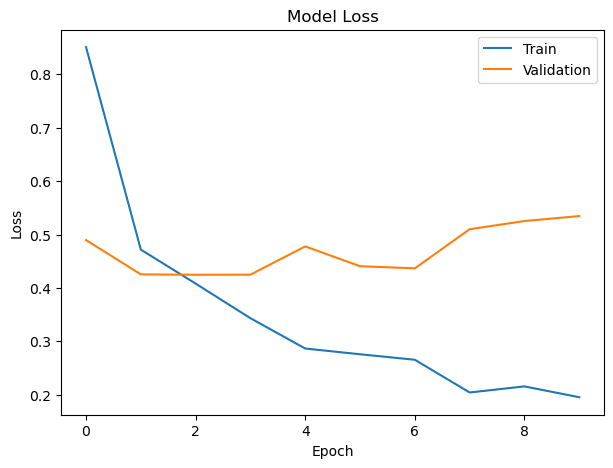

In [28]:
# Plot Model Loss graph
plot_graph(history,'loss')

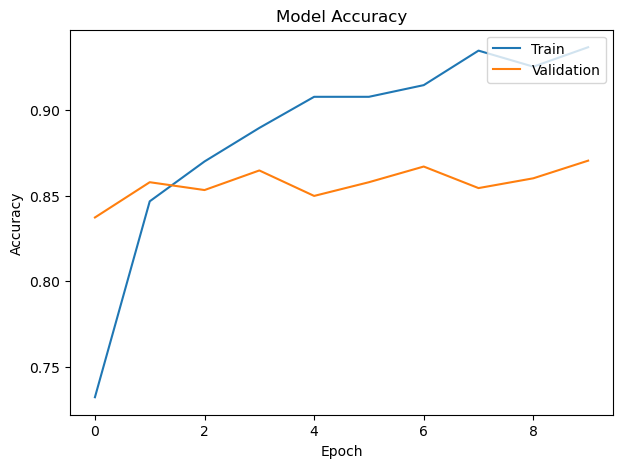

In [29]:
# Plot Model Accuracy graph
plot_graph(history,'accuracy')

In [30]:
# Evaluate Model
evalaution_metrics('CNN(ResNet152V2 Transfer Learning)','resnet152_model.h5' )

The accuracy of the CNN(ResNet152V2 Transfer Learning) model is 0.8706
The loss of the CNN(ResNet152V2 Transfer Learning) model is 0.4531


### K - CNN Model with Transfer Learning - VGG16


In [31]:
# Initialize a VGG16 model for transfer learning with specific settings:
model = VGG16(input_shape=(256,256, 3),pooling='avg',weights = 'imagenet',include_top=False)

In [32]:
# Using model functions created earlier:
model = create_model_arch(model)
model = compile_model(model,0.001)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [33]:
# Train the model using callbacks
history = model.fit(
    train_dataset, # Training dataset generator
    epochs=10, # Number of training epochs
    validation_data=validation_dataset, # Validation dataset generator
    callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=4, verbose=2), # Perform early stopping based on validation accuracy
    ModelCheckpoint(filepath='./vgg16_model.h5', monitor='val_accuracy', verbose=0, save_best_only=True)
    ]
)

Epoch 1/10
55/55 [==============================] - 469s 9s/step - loss: 2.3236 - accuracy: 0.2103 - val_loss: 2.0064 - val_accuracy: 0.3356
Epoch 2/10
55/55 [==============================] - 468s 9s/step - loss: 1.7797 - accuracy: 0.4179 - val_loss: 1.5807 - val_accuracy: 0.5040
Epoch 3/10
55/55 [==============================] - 466s 8s/step - loss: 1.4604 - accuracy: 0.5165 - val_loss: 1.3338 - val_accuracy: 0.5659
Epoch 4/10
55/55 [==============================] - 462s 8s/step - loss: 1.3141 - accuracy: 0.5642 - val_loss: 1.2808 - val_accuracy: 0.5808
Epoch 5/10
55/55 [==============================] - 458s 8s/step - loss: 1.2315 - accuracy: 0.5915 - val_loss: 1.1905 - val_accuracy: 0.6082
Epoch 6/10
55/55 [==============================] - 1543s 28s/step - loss: 1.1461 - accuracy: 0.6154 - val_loss: 1.1632 - val_accuracy: 0.6071
Epoch 7/10
55/55 [==============================] - 468s 9s/step - loss: 1.0940 - accuracy: 0.6373 - val_loss: 1.1375 - val_accuracy: 0.6174
Epoch 8/10


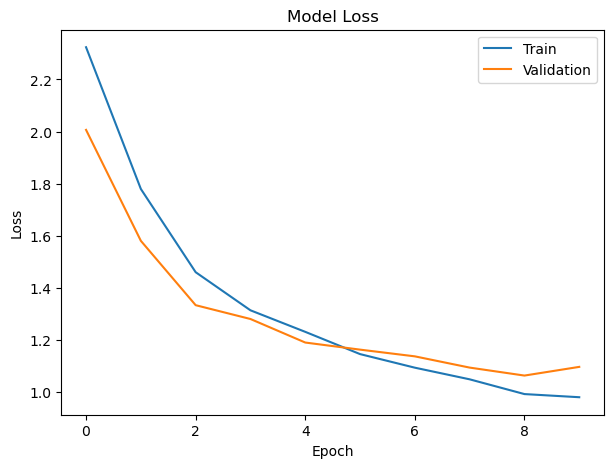

In [34]:
# Plot Model Loss graph
plot_graph(history,'loss')

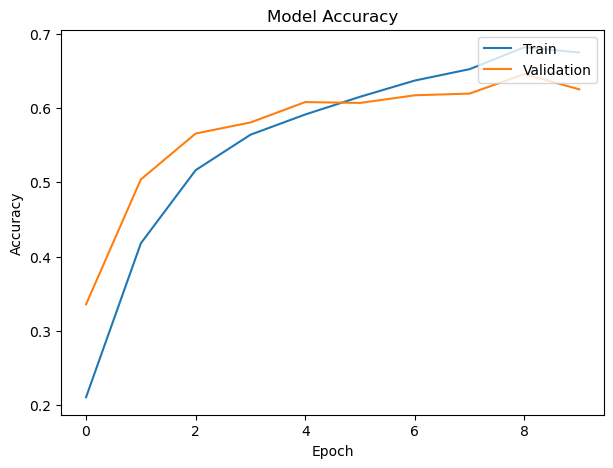

In [35]:
# Plot Model Accuracy graph
plot_graph(history,'accuracy')

In [36]:
# Evaluate Model
evalaution_metrics('CNN(VGG16 Transfer Learning)','vgg16_model.h5' )

The accuracy of the CNN(VGG16 Transfer Learning) model is 0.6598
The loss of the CNN(VGG16 Transfer Learning) model is 1.0426


### L - CNN Model with Transfer Learning - InceptionV3

In [37]:
# Initialize an Inception model for transfer learning with specific settings:
model = InceptionV3(input_shape=(256,256, 3),pooling='avg',weights = 'imagenet',include_top=False)

In [38]:
# Using model functions created earlier:
model = create_model_arch(model)
model = compile_model(model,0.001)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 127, 127, 32)         864       ['input_4[0][0]']             
                                                                                                  
 batch_normalization_3 (Bat  (None, 127, 127, 32)         96        ['conv2d_3[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation (Activation)     (None, 127, 127, 32)         0         ['batch_normalization_3[

                                                                                                  
 conv2d_14 (Conv2D)          (None, 29, 29, 32)           6144      ['average_pooling2d[0][0]']   
                                                                                                  
 batch_normalization_8 (Bat  (None, 29, 29, 64)           192       ['conv2d_8[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_10 (Ba  (None, 29, 29, 64)           192       ['conv2d_10[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_13 (Ba  (None, 29, 29, 96)           288       ['conv2d_13[0][0]']           
 tchNormal

                                                                    ']                            
                                                                                                  
 activation_17 (Activation)  (None, 29, 29, 96)           0         ['batch_normalization_20[0][0]
                                                                    ']                            
                                                                                                  
 activation_18 (Activation)  (None, 29, 29, 64)           0         ['batch_normalization_21[0][0]
                                                                    ']                            
                                                                                                  
 mixed1 (Concatenate)        (None, 29, 29, 288)          0         ['activation_12[0][0]',       
                                                                     'activation_14[0][0]',       
          

                                                                    ']                            
                                                                                                  
 conv2d_31 (Conv2D)          (None, 29, 29, 96)           55296     ['activation_27[0][0]']       
                                                                                                  
 batch_normalization_31 (Ba  (None, 29, 29, 96)           288       ['conv2d_31[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_28 (Activation)  (None, 29, 29, 96)           0         ['batch_normalization_31[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_29

                                                                                                  
 conv2d_33 (Conv2D)          (None, 14, 14, 192)          147456    ['mixed3[0][0]']              
                                                                                                  
 conv2d_36 (Conv2D)          (None, 14, 14, 192)          172032    ['activation_32[0][0]']       
                                                                                                  
 conv2d_41 (Conv2D)          (None, 14, 14, 192)          172032    ['activation_37[0][0]']       
                                                                                                  
 conv2d_42 (Conv2D)          (None, 14, 14, 192)          147456    ['average_pooling2d_3[0][0]'] 
                                                                                                  
 batch_normalization_33 (Ba  (None, 14, 14, 192)          576       ['conv2d_33[0][0]']           
 tchNormal

 activation_47 (Activation)  (None, 14, 14, 160)          0         ['batch_normalization_50[0][0]
                                                                    ']                            
                                                                                                  
 average_pooling2d_4 (Avera  (None, 14, 14, 768)          0         ['mixed4[0][0]']              
 gePooling2D)                                                                                     
                                                                                                  
 conv2d_43 (Conv2D)          (None, 14, 14, 192)          147456    ['mixed4[0][0]']              
                                                                                                  
 conv2d_46 (Conv2D)          (None, 14, 14, 192)          215040    ['activation_42[0][0]']       
                                                                                                  
 conv2d_51

 tchNormalization)                                                                                
                                                                                                  
 activation_52 (Activation)  (None, 14, 14, 160)          0         ['batch_normalization_55[0][0]
                                                                    ']                            
                                                                                                  
 activation_57 (Activation)  (None, 14, 14, 160)          0         ['batch_normalization_60[0][0]
                                                                    ']                            
                                                                                                  
 average_pooling2d_5 (Avera  (None, 14, 14, 768)          0         ['mixed5[0][0]']              
 gePooling2D)                                                                                     
          

                                                                                                  
 batch_normalization_65 (Ba  (None, 14, 14, 192)          576       ['conv2d_65[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_70 (Ba  (None, 14, 14, 192)          576       ['conv2d_70[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_62 (Activation)  (None, 14, 14, 192)          0         ['batch_normalization_65[0][0]
                                                                    ']                            
                                                                                                  
 activatio

                                                                    ']                            
                                                                                                  
 conv2d_74 (Conv2D)          (None, 6, 6, 320)            552960    ['activation_70[0][0]']       
                                                                                                  
 conv2d_78 (Conv2D)          (None, 6, 6, 192)            331776    ['activation_74[0][0]']       
                                                                                                  
 batch_normalization_74 (Ba  (None, 6, 6, 320)            960       ['conv2d_74[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_78 (Ba  (None, 6, 6, 192)            576       ['conv2d_78[0][0]']           
 tchNormal

                                                                    ']                            
                                                                                                  
 activation_82 (Activation)  (None, 6, 6, 384)            0         ['batch_normalization_85[0][0]
                                                                    ']                            
                                                                                                  
 activation_83 (Activation)  (None, 6, 6, 384)            0         ['batch_normalization_86[0][0]
                                                                    ']                            
                                                                                                  
 batch_normalization_87 (Ba  (None, 6, 6, 192)            576       ['conv2d_87[0][0]']           
 tchNormalization)                                                                                
          

                                                                    ']                            
                                                                                                  
 activation_88 (Activation)  (None, 6, 6, 384)            0         ['batch_normalization_91[0][0]
                                                                    ']                            
                                                                                                  
 activation_91 (Activation)  (None, 6, 6, 384)            0         ['batch_normalization_94[0][0]
                                                                    ']                            
                                                                                                  
 activation_92 (Activation)  (None, 6, 6, 384)            0         ['batch_normalization_95[0][0]
                                                                    ']                            
          

In [39]:
# Train the model using callbacks
history = model.fit(
    train_dataset, # Training dataset generator
    epochs=10, # Number of training epochs
    validation_data=validation_dataset, # Validation dataset generator
    callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=4, verbose=2), # Perform early stopping based on validation accuracy
    ModelCheckpoint(filepath='./inceptionv3_model.h5', monitor='val_accuracy', verbose=0, save_best_only=True)
    ]
)

Epoch 1/10
55/55 [==============================] - 103s 2s/step - loss: 0.9250 - accuracy: 0.7032 - val_loss: 0.4597 - val_accuracy: 0.8648
Epoch 2/10
55/55 [==============================] - 100s 2s/step - loss: 0.5561 - accuracy: 0.8275 - val_loss: 0.4303 - val_accuracy: 0.8603
Epoch 3/10
55/55 [==============================] - 104s 2s/step - loss: 0.4865 - accuracy: 0.8482 - val_loss: 0.4445 - val_accuracy: 0.8625
Epoch 4/10
55/55 [==============================] - 105s 2s/step - loss: 0.4772 - accuracy: 0.8445 - val_loss: 0.4256 - val_accuracy: 0.8694
Epoch 5/10
55/55 [==============================] - 105s 2s/step - loss: 0.4216 - accuracy: 0.8701 - val_loss: 0.4131 - val_accuracy: 0.8660
Epoch 6/10
55/55 [==============================] - 104s 2s/step - loss: 0.3798 - accuracy: 0.8761 - val_loss: 0.4254 - val_accuracy: 0.8625
Epoch 7/10
55/55 [==============================] - 104s 2s/step - loss: 0.3828 - accuracy: 0.8789 - val_loss: 0.3980 - val_accuracy: 0.8591
Epoch 8/10
55

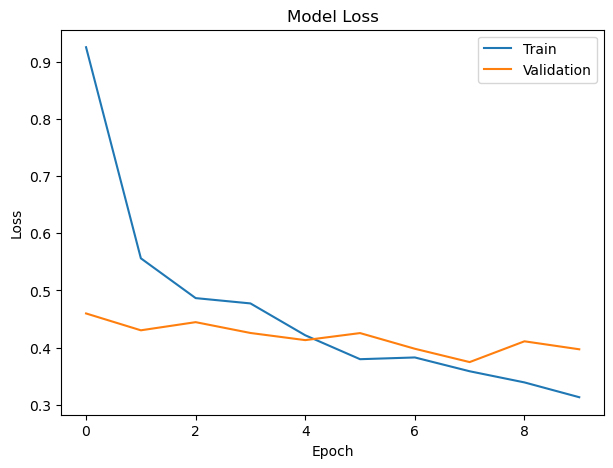

In [40]:
# Plot Model Loss graph
plot_graph(history,'loss')

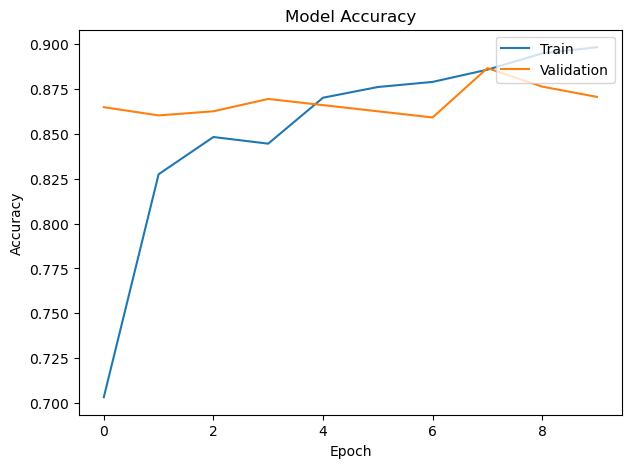

In [41]:
# Plot Model Accuracy graph
plot_graph(history,'accuracy')

In [42]:
# Evaluate Model
evalaution_metrics('CNN(InceptionV3 Transfer Learning)','inceptionv3_model.h5' )

The accuracy of the CNN(InceptionV3 Transfer Learning) model is 0.8580
The loss of the CNN(InceptionV3 Transfer Learning) model is 0.4173


### N - Tweak Learning Rate of Best Performing Model (ResNet152V2): Learning rate = 0.1

In [43]:
# Initialize a ResNet152V2 model for transfer learning with specific settings:
model = ResNet152V2(input_shape=(256,256, 3),pooling='avg',weights = 'imagenet',include_top=False)

# Using model functions created earlier:
model = create_model_arch(model)
model = compile_model(model,0.1)

# Train the model using callbacks
history = model.fit(
    train_dataset, # Training dataset generator
    epochs=10, # Number of training epochs
    validation_data=validation_dataset, # Validation dataset generator
    callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=4, verbose=2), # Perform early stopping based on validation accuracy
    ModelCheckpoint(filepath='./resnet152v2L0_1.h5', monitor='val_accuracy', verbose=0, save_best_only=True)
    ]
)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_5[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 130, 130, 64)         0         ['conv1_conv[0][0]']          
                                                                                            

 tchNormalization)                                                                                
                                                                                                  
 conv2_block3_preact_relu (  (None, 64, 64, 256)          0         ['conv2_block3_preact_bn[0][0]
 Activation)                                                        ']                            
                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 64, 64, 64)           16384     ['conv2_block3_preact_relu[0][
 D)                                                                 0]']                          
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 64, 64, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
          

 conv3_block2_1_relu (Activ  (None, 32, 32, 128)          0         ['conv3_block2_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block2_2_pad (ZeroPa  (None, 34, 34, 128)          0         ['conv3_block2_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv3_block2_2_conv (Conv2  (None, 32, 32, 128)          147456    ['conv3_block2_2_pad[0][0]']  
 D)                                                                                               
                                                                                                  
 conv3_block2_2_bn (BatchNo  (None, 32, 32, 128)          512       ['conv3_block2_2_conv[0][0]'] 
 rmalizati

                                                                                                  
 conv3_block4_out (Add)      (None, 32, 32, 512)          0         ['conv3_block3_out[0][0]',    
                                                                     'conv3_block4_3_conv[0][0]'] 
                                                                                                  
 conv3_block5_preact_bn (Ba  (None, 32, 32, 512)          2048      ['conv3_block4_out[0][0]']    
 tchNormalization)                                                                                
                                                                                                  
 conv3_block5_preact_relu (  (None, 32, 32, 512)          0         ['conv3_block5_preact_bn[0][0]
 Activation)                                                        ']                            
                                                                                                  
 conv3_blo

 ation)                                                                                           
                                                                                                  
 conv3_block7_2_pad (ZeroPa  (None, 34, 34, 128)          0         ['conv3_block7_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv3_block7_2_conv (Conv2  (None, 32, 32, 128)          147456    ['conv3_block7_2_pad[0][0]']  
 D)                                                                                               
                                                                                                  
 conv3_block7_2_bn (BatchNo  (None, 32, 32, 128)          512       ['conv3_block7_2_conv[0][0]'] 
 rmalization)                                                                                     
          

 conv4_block1_0_conv (Conv2  (None, 16, 16, 1024)         525312    ['conv4_block1_preact_relu[0][
 D)                                                                 0]']                          
                                                                                                  
 conv4_block1_3_conv (Conv2  (None, 16, 16, 1024)         263168    ['conv4_block1_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_out (Add)      (None, 16, 16, 1024)         0         ['conv4_block1_0_conv[0][0]', 
                                                                     'conv4_block1_3_conv[0][0]'] 
                                                                                                  
 conv4_block2_preact_bn (Ba  (None, 16, 16, 1024)         4096      ['conv4_block1_out[0][0]']    
 tchNormal

                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 16, 16, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block4_1_relu (Activ  (None, 16, 16, 256)          0         ['conv4_block4_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block4_2_pad (ZeroPa  (None, 18, 18, 256)          0         ['conv4_block4_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv4_blo

 ation)                                                                                           
                                                                                                  
 conv4_block6_3_conv (Conv2  (None, 16, 16, 1024)         263168    ['conv4_block6_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block6_out (Add)      (None, 16, 16, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_conv[0][0]'] 
                                                                                                  
 conv4_block7_preact_bn (Ba  (None, 16, 16, 1024)         4096      ['conv4_block6_out[0][0]']    
 tchNormalization)                                                                                
          

 conv4_block9_1_bn (BatchNo  (None, 16, 16, 256)          1024      ['conv4_block9_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block9_1_relu (Activ  (None, 16, 16, 256)          0         ['conv4_block9_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block9_2_pad (ZeroPa  (None, 18, 18, 256)          0         ['conv4_block9_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv4_block9_2_conv (Conv2  (None, 16, 16, 256)          589824    ['conv4_block9_2_pad[0][0]']  
 D)       

                                                                                                  
 conv4_block11_3_conv (Conv  (None, 16, 16, 1024)         263168    ['conv4_block11_2_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block11_out (Add)     (None, 16, 16, 1024)         0         ['conv4_block10_out[0][0]',   
                                                                     'conv4_block11_3_conv[0][0]']
                                                                                                  
 conv4_block12_preact_bn (B  (None, 16, 16, 1024)         4096      ['conv4_block11_out[0][0]']   
 atchNormalization)                                                                               
                                                                                                  
 conv4_blo

 ormalization)                                                                                    
                                                                                                  
 conv4_block14_1_relu (Acti  (None, 16, 16, 256)          0         ['conv4_block14_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block14_2_pad (ZeroP  (None, 18, 18, 256)          0         ['conv4_block14_1_relu[0][0]']
 adding2D)                                                                                        
                                                                                                  
 conv4_block14_2_conv (Conv  (None, 16, 16, 256)          589824    ['conv4_block14_2_pad[0][0]'] 
 2D)                                                                                              
          

 conv4_block16_3_conv (Conv  (None, 16, 16, 1024)         263168    ['conv4_block16_2_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block16_out (Add)     (None, 16, 16, 1024)         0         ['conv4_block15_out[0][0]',   
                                                                     'conv4_block16_3_conv[0][0]']
                                                                                                  
 conv4_block17_preact_bn (B  (None, 16, 16, 1024)         4096      ['conv4_block16_out[0][0]']   
 atchNormalization)                                                                               
                                                                                                  
 conv4_block17_preact_relu   (None, 16, 16, 1024)         0         ['conv4_block17_preact_bn[0][0
 (Activati

                                                                                                  
 conv4_block19_1_relu (Acti  (None, 16, 16, 256)          0         ['conv4_block19_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block19_2_pad (ZeroP  (None, 18, 18, 256)          0         ['conv4_block19_1_relu[0][0]']
 adding2D)                                                                                        
                                                                                                  
 conv4_block19_2_conv (Conv  (None, 16, 16, 256)          589824    ['conv4_block19_2_pad[0][0]'] 
 2D)                                                                                              
                                                                                                  
 conv4_blo

 2D)                                                                                              
                                                                                                  
 conv4_block21_out (Add)     (None, 16, 16, 1024)         0         ['conv4_block20_out[0][0]',   
                                                                     'conv4_block21_3_conv[0][0]']
                                                                                                  
 conv4_block22_preact_bn (B  (None, 16, 16, 1024)         4096      ['conv4_block21_out[0][0]']   
 atchNormalization)                                                                               
                                                                                                  
 conv4_block22_preact_relu   (None, 16, 16, 1024)         0         ['conv4_block22_preact_bn[0][0
 (Activation)                                                       ]']                           
          

 conv4_block24_1_relu (Acti  (None, 16, 16, 256)          0         ['conv4_block24_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block24_2_pad (ZeroP  (None, 18, 18, 256)          0         ['conv4_block24_1_relu[0][0]']
 adding2D)                                                                                        
                                                                                                  
 conv4_block24_2_conv (Conv  (None, 16, 16, 256)          589824    ['conv4_block24_2_pad[0][0]'] 
 2D)                                                                                              
                                                                                                  
 conv4_block24_2_bn (BatchN  (None, 16, 16, 256)          1024      ['conv4_block24_2_conv[0][0]']
 ormalizat

                                                                                                  
 conv4_block26_out (Add)     (None, 16, 16, 1024)         0         ['conv4_block25_out[0][0]',   
                                                                     'conv4_block26_3_conv[0][0]']
                                                                                                  
 conv4_block27_preact_bn (B  (None, 16, 16, 1024)         4096      ['conv4_block26_out[0][0]']   
 atchNormalization)                                                                               
                                                                                                  
 conv4_block27_preact_relu   (None, 16, 16, 1024)         0         ['conv4_block27_preact_bn[0][0
 (Activation)                                                       ]']                           
                                                                                                  
 conv4_blo

 vation)                                                                                          
                                                                                                  
 conv4_block29_2_pad (ZeroP  (None, 18, 18, 256)          0         ['conv4_block29_1_relu[0][0]']
 adding2D)                                                                                        
                                                                                                  
 conv4_block29_2_conv (Conv  (None, 16, 16, 256)          589824    ['conv4_block29_2_pad[0][0]'] 
 2D)                                                                                              
                                                                                                  
 conv4_block29_2_bn (BatchN  (None, 16, 16, 256)          1024      ['conv4_block29_2_conv[0][0]']
 ormalization)                                                                                    
          

 conv4_block31_out (Add)     (None, 16, 16, 1024)         0         ['conv4_block30_out[0][0]',   
                                                                     'conv4_block31_3_conv[0][0]']
                                                                                                  
 conv4_block32_preact_bn (B  (None, 16, 16, 1024)         4096      ['conv4_block31_out[0][0]']   
 atchNormalization)                                                                               
                                                                                                  
 conv4_block32_preact_relu   (None, 16, 16, 1024)         0         ['conv4_block32_preact_bn[0][0
 (Activation)                                                       ]']                           
                                                                                                  
 conv4_block32_1_conv (Conv  (None, 16, 16, 256)          262144    ['conv4_block32_preact_relu[0]
 2D)      

                                                                                                  
 conv4_block34_2_pad (ZeroP  (None, 18, 18, 256)          0         ['conv4_block34_1_relu[0][0]']
 adding2D)                                                                                        
                                                                                                  
 conv4_block34_2_conv (Conv  (None, 16, 16, 256)          589824    ['conv4_block34_2_pad[0][0]'] 
 2D)                                                                                              
                                                                                                  
 conv4_block34_2_bn (BatchN  (None, 16, 16, 256)          1024      ['conv4_block34_2_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_blo

 2D)                                                                                              
                                                                                                  
 conv4_block36_out (Add)     (None, 8, 8, 1024)           0         ['max_pooling2d_12[0][0]',    
                                                                     'conv4_block36_3_conv[0][0]']
                                                                                                  
 conv5_block1_preact_bn (Ba  (None, 8, 8, 1024)           4096      ['conv4_block36_out[0][0]']   
 tchNormalization)                                                                                
                                                                                                  
 conv5_block1_preact_relu (  (None, 8, 8, 1024)           0         ['conv5_block1_preact_bn[0][0]
 Activation)                                                        ']                            
          

 conv5_block3_1_bn (BatchNo  (None, 8, 8, 512)            2048      ['conv5_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_1_relu (Activ  (None, 8, 8, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_pad (ZeroPa  (None, 10, 10, 512)          0         ['conv5_block3_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 8, 8, 512)            2359296   ['conv5_block3_2_pad[0][0]']  
 D)       

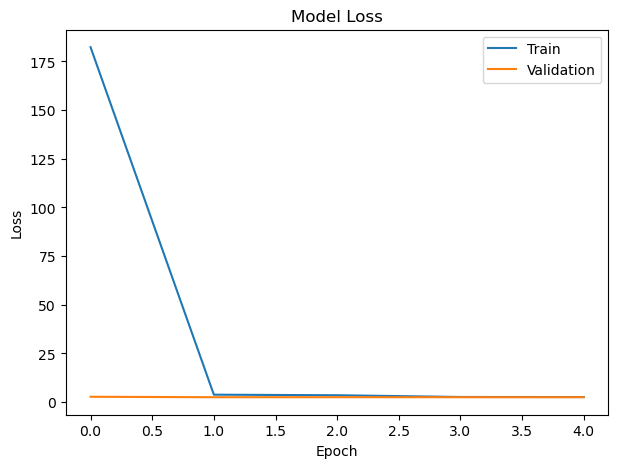

In [44]:
# Plot Model Loss graph
plot_graph(history,'loss')

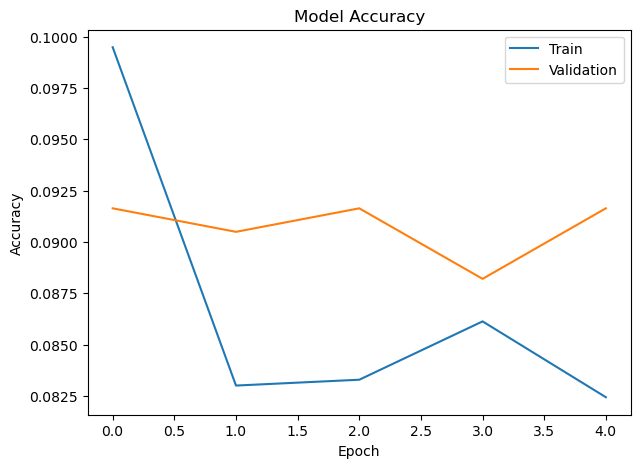

In [45]:
# Plot Model Accuracy graph
plot_graph(history,'accuracy')

In [46]:
# Evaluate Model
evalaution_metrics('CNN(ResNet152V2 - Learning Rate 0.1)','resnet152v2L0_1.h5' )

The accuracy of the CNN(ResNet152V2 - Learning Rate 0.1) model is 0.0916
The loss of the CNN(ResNet152V2 - Learning Rate 0.1) model is 3.8468


### O - Tweak Learning Rate of Best Performing Model (ResNet152V2): Learning rate = 0.01

In [47]:
# Initialize a ResNet152V2 model for transfer learning with specific settings:
model = ResNet152V2(input_shape=(256,256, 3),pooling='avg',weights = 'imagenet',include_top=False)

# Using model functions created earlier:
model = create_model_arch(model)
model = compile_model(model,0.01)

# Train the model using callbacks
history = model.fit(
    train_dataset, # Training dataset generator
    epochs=10, # Number of training epochs
    validation_data=validation_dataset, # Validation dataset generator
    callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=4, verbose=2), # Perform early stopping based on validation accuracy
    ModelCheckpoint(filepath='./resnet152v2L0_01.h5', monitor='val_accuracy', verbose=0, save_best_only=True)
    ]
)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_6[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 130, 130, 64)         0         ['conv1_conv[0][0]']          
                                                                                            

 tchNormalization)                                                                                
                                                                                                  
 conv2_block3_preact_relu (  (None, 64, 64, 256)          0         ['conv2_block3_preact_bn[0][0]
 Activation)                                                        ']                            
                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 64, 64, 64)           16384     ['conv2_block3_preact_relu[0][
 D)                                                                 0]']                          
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 64, 64, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
          

 conv3_block2_1_relu (Activ  (None, 32, 32, 128)          0         ['conv3_block2_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block2_2_pad (ZeroPa  (None, 34, 34, 128)          0         ['conv3_block2_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv3_block2_2_conv (Conv2  (None, 32, 32, 128)          147456    ['conv3_block2_2_pad[0][0]']  
 D)                                                                                               
                                                                                                  
 conv3_block2_2_bn (BatchNo  (None, 32, 32, 128)          512       ['conv3_block2_2_conv[0][0]'] 
 rmalizati

                                                                                                  
 conv3_block4_out (Add)      (None, 32, 32, 512)          0         ['conv3_block3_out[0][0]',    
                                                                     'conv3_block4_3_conv[0][0]'] 
                                                                                                  
 conv3_block5_preact_bn (Ba  (None, 32, 32, 512)          2048      ['conv3_block4_out[0][0]']    
 tchNormalization)                                                                                
                                                                                                  
 conv3_block5_preact_relu (  (None, 32, 32, 512)          0         ['conv3_block5_preact_bn[0][0]
 Activation)                                                        ']                            
                                                                                                  
 conv3_blo

 ation)                                                                                           
                                                                                                  
 conv3_block7_2_pad (ZeroPa  (None, 34, 34, 128)          0         ['conv3_block7_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv3_block7_2_conv (Conv2  (None, 32, 32, 128)          147456    ['conv3_block7_2_pad[0][0]']  
 D)                                                                                               
                                                                                                  
 conv3_block7_2_bn (BatchNo  (None, 32, 32, 128)          512       ['conv3_block7_2_conv[0][0]'] 
 rmalization)                                                                                     
          

 conv4_block1_0_conv (Conv2  (None, 16, 16, 1024)         525312    ['conv4_block1_preact_relu[0][
 D)                                                                 0]']                          
                                                                                                  
 conv4_block1_3_conv (Conv2  (None, 16, 16, 1024)         263168    ['conv4_block1_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_out (Add)      (None, 16, 16, 1024)         0         ['conv4_block1_0_conv[0][0]', 
                                                                     'conv4_block1_3_conv[0][0]'] 
                                                                                                  
 conv4_block2_preact_bn (Ba  (None, 16, 16, 1024)         4096      ['conv4_block1_out[0][0]']    
 tchNormal

                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 16, 16, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block4_1_relu (Activ  (None, 16, 16, 256)          0         ['conv4_block4_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block4_2_pad (ZeroPa  (None, 18, 18, 256)          0         ['conv4_block4_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv4_blo

 ation)                                                                                           
                                                                                                  
 conv4_block6_3_conv (Conv2  (None, 16, 16, 1024)         263168    ['conv4_block6_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block6_out (Add)      (None, 16, 16, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_conv[0][0]'] 
                                                                                                  
 conv4_block7_preact_bn (Ba  (None, 16, 16, 1024)         4096      ['conv4_block6_out[0][0]']    
 tchNormalization)                                                                                
          

 conv4_block9_1_bn (BatchNo  (None, 16, 16, 256)          1024      ['conv4_block9_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block9_1_relu (Activ  (None, 16, 16, 256)          0         ['conv4_block9_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block9_2_pad (ZeroPa  (None, 18, 18, 256)          0         ['conv4_block9_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv4_block9_2_conv (Conv2  (None, 16, 16, 256)          589824    ['conv4_block9_2_pad[0][0]']  
 D)       

                                                                                                  
 conv4_block11_3_conv (Conv  (None, 16, 16, 1024)         263168    ['conv4_block11_2_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block11_out (Add)     (None, 16, 16, 1024)         0         ['conv4_block10_out[0][0]',   
                                                                     'conv4_block11_3_conv[0][0]']
                                                                                                  
 conv4_block12_preact_bn (B  (None, 16, 16, 1024)         4096      ['conv4_block11_out[0][0]']   
 atchNormalization)                                                                               
                                                                                                  
 conv4_blo

 ormalization)                                                                                    
                                                                                                  
 conv4_block14_1_relu (Acti  (None, 16, 16, 256)          0         ['conv4_block14_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block14_2_pad (ZeroP  (None, 18, 18, 256)          0         ['conv4_block14_1_relu[0][0]']
 adding2D)                                                                                        
                                                                                                  
 conv4_block14_2_conv (Conv  (None, 16, 16, 256)          589824    ['conv4_block14_2_pad[0][0]'] 
 2D)                                                                                              
          

 conv4_block16_3_conv (Conv  (None, 16, 16, 1024)         263168    ['conv4_block16_2_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block16_out (Add)     (None, 16, 16, 1024)         0         ['conv4_block15_out[0][0]',   
                                                                     'conv4_block16_3_conv[0][0]']
                                                                                                  
 conv4_block17_preact_bn (B  (None, 16, 16, 1024)         4096      ['conv4_block16_out[0][0]']   
 atchNormalization)                                                                               
                                                                                                  
 conv4_block17_preact_relu   (None, 16, 16, 1024)         0         ['conv4_block17_preact_bn[0][0
 (Activati

                                                                                                  
 conv4_block19_1_relu (Acti  (None, 16, 16, 256)          0         ['conv4_block19_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block19_2_pad (ZeroP  (None, 18, 18, 256)          0         ['conv4_block19_1_relu[0][0]']
 adding2D)                                                                                        
                                                                                                  
 conv4_block19_2_conv (Conv  (None, 16, 16, 256)          589824    ['conv4_block19_2_pad[0][0]'] 
 2D)                                                                                              
                                                                                                  
 conv4_blo

 2D)                                                                                              
                                                                                                  
 conv4_block21_out (Add)     (None, 16, 16, 1024)         0         ['conv4_block20_out[0][0]',   
                                                                     'conv4_block21_3_conv[0][0]']
                                                                                                  
 conv4_block22_preact_bn (B  (None, 16, 16, 1024)         4096      ['conv4_block21_out[0][0]']   
 atchNormalization)                                                                               
                                                                                                  
 conv4_block22_preact_relu   (None, 16, 16, 1024)         0         ['conv4_block22_preact_bn[0][0
 (Activation)                                                       ]']                           
          

 conv4_block24_1_relu (Acti  (None, 16, 16, 256)          0         ['conv4_block24_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block24_2_pad (ZeroP  (None, 18, 18, 256)          0         ['conv4_block24_1_relu[0][0]']
 adding2D)                                                                                        
                                                                                                  
 conv4_block24_2_conv (Conv  (None, 16, 16, 256)          589824    ['conv4_block24_2_pad[0][0]'] 
 2D)                                                                                              
                                                                                                  
 conv4_block24_2_bn (BatchN  (None, 16, 16, 256)          1024      ['conv4_block24_2_conv[0][0]']
 ormalizat

                                                                                                  
 conv4_block26_out (Add)     (None, 16, 16, 1024)         0         ['conv4_block25_out[0][0]',   
                                                                     'conv4_block26_3_conv[0][0]']
                                                                                                  
 conv4_block27_preact_bn (B  (None, 16, 16, 1024)         4096      ['conv4_block26_out[0][0]']   
 atchNormalization)                                                                               
                                                                                                  
 conv4_block27_preact_relu   (None, 16, 16, 1024)         0         ['conv4_block27_preact_bn[0][0
 (Activation)                                                       ]']                           
                                                                                                  
 conv4_blo

 vation)                                                                                          
                                                                                                  
 conv4_block29_2_pad (ZeroP  (None, 18, 18, 256)          0         ['conv4_block29_1_relu[0][0]']
 adding2D)                                                                                        
                                                                                                  
 conv4_block29_2_conv (Conv  (None, 16, 16, 256)          589824    ['conv4_block29_2_pad[0][0]'] 
 2D)                                                                                              
                                                                                                  
 conv4_block29_2_bn (BatchN  (None, 16, 16, 256)          1024      ['conv4_block29_2_conv[0][0]']
 ormalization)                                                                                    
          

 conv4_block31_out (Add)     (None, 16, 16, 1024)         0         ['conv4_block30_out[0][0]',   
                                                                     'conv4_block31_3_conv[0][0]']
                                                                                                  
 conv4_block32_preact_bn (B  (None, 16, 16, 1024)         4096      ['conv4_block31_out[0][0]']   
 atchNormalization)                                                                               
                                                                                                  
 conv4_block32_preact_relu   (None, 16, 16, 1024)         0         ['conv4_block32_preact_bn[0][0
 (Activation)                                                       ]']                           
                                                                                                  
 conv4_block32_1_conv (Conv  (None, 16, 16, 256)          262144    ['conv4_block32_preact_relu[0]
 2D)      

                                                                                                  
 conv4_block34_2_pad (ZeroP  (None, 18, 18, 256)          0         ['conv4_block34_1_relu[0][0]']
 adding2D)                                                                                        
                                                                                                  
 conv4_block34_2_conv (Conv  (None, 16, 16, 256)          589824    ['conv4_block34_2_pad[0][0]'] 
 2D)                                                                                              
                                                                                                  
 conv4_block34_2_bn (BatchN  (None, 16, 16, 256)          1024      ['conv4_block34_2_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_blo

 2D)                                                                                              
                                                                                                  
 conv4_block36_out (Add)     (None, 8, 8, 1024)           0         ['max_pooling2d_15[0][0]',    
                                                                     'conv4_block36_3_conv[0][0]']
                                                                                                  
 conv5_block1_preact_bn (Ba  (None, 8, 8, 1024)           4096      ['conv4_block36_out[0][0]']   
 tchNormalization)                                                                                
                                                                                                  
 conv5_block1_preact_relu (  (None, 8, 8, 1024)           0         ['conv5_block1_preact_bn[0][0]
 Activation)                                                        ']                            
          

 conv5_block3_1_bn (BatchNo  (None, 8, 8, 512)            2048      ['conv5_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_1_relu (Activ  (None, 8, 8, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_pad (ZeroPa  (None, 10, 10, 512)          0         ['conv5_block3_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 8, 8, 512)            2359296   ['conv5_block3_2_pad[0][0]']  
 D)       

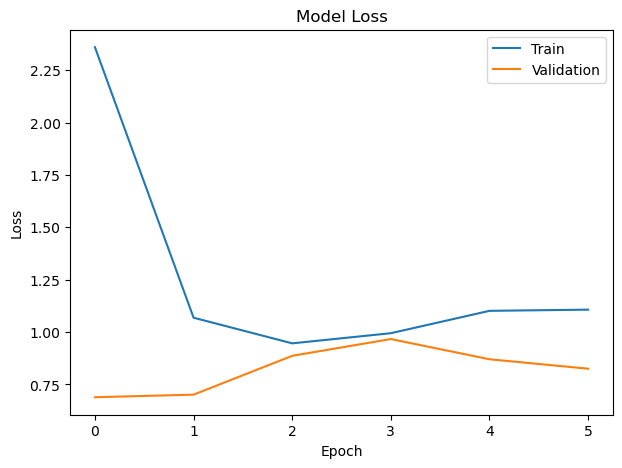

In [48]:
# Plot Model Loss graph
plot_graph(history,'loss')

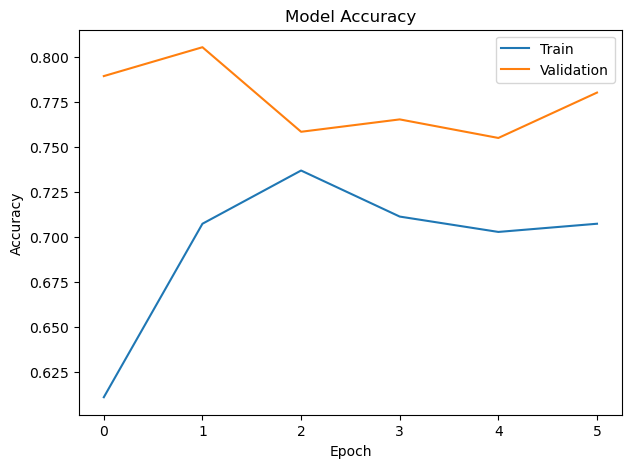

In [49]:
# Plot Model Accuracy graph
plot_graph(history,'accuracy')

In [50]:
# Evaluate Model
evalaution_metrics('CNN(ResNet152V2 - Learning Rate 0.01)','resnet152v2L0_01.h5' )

The accuracy of the CNN(ResNet152V2 - Learning Rate 0.01) model is 0.8225
The loss of the CNN(ResNet152V2 - Learning Rate 0.01) model is 0.6703


### P - Tweak Learning Rate of Best Performing Model (ResNet152V2): Learning rate = 0.0001

In [51]:
# Initialize a ResNet152V2 model for transfer learning with specific settings:
model = ResNet152V2(input_shape=(256,256, 3),pooling='avg',weights = 'imagenet',include_top=False)

# Using model functions created earlier:
model = create_model_arch(model)
model = compile_model(model,0.0001)

# Train the model using callbacks
history = model.fit(
    train_dataset, # Training dataset generator
    epochs=10, # Number of training epochs
    validation_data=validation_dataset, # Validation dataset generator
    callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=4, verbose=2), # Perform early stopping based on validation accuracy
    ModelCheckpoint(filepath='./resnet152v2L0_0001.h5', monitor='val_accuracy', verbose=0, save_best_only=True)
    ]
)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_7[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 130, 130, 64)         0         ['conv1_conv[0][0]']          
                                                                                            

 tchNormalization)                                                                                
                                                                                                  
 conv2_block3_preact_relu (  (None, 64, 64, 256)          0         ['conv2_block3_preact_bn[0][0]
 Activation)                                                        ']                            
                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 64, 64, 64)           16384     ['conv2_block3_preact_relu[0][
 D)                                                                 0]']                          
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 64, 64, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
          

 conv3_block2_1_relu (Activ  (None, 32, 32, 128)          0         ['conv3_block2_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block2_2_pad (ZeroPa  (None, 34, 34, 128)          0         ['conv3_block2_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv3_block2_2_conv (Conv2  (None, 32, 32, 128)          147456    ['conv3_block2_2_pad[0][0]']  
 D)                                                                                               
                                                                                                  
 conv3_block2_2_bn (BatchNo  (None, 32, 32, 128)          512       ['conv3_block2_2_conv[0][0]'] 
 rmalizati

                                                                                                  
 conv3_block4_out (Add)      (None, 32, 32, 512)          0         ['conv3_block3_out[0][0]',    
                                                                     'conv3_block4_3_conv[0][0]'] 
                                                                                                  
 conv3_block5_preact_bn (Ba  (None, 32, 32, 512)          2048      ['conv3_block4_out[0][0]']    
 tchNormalization)                                                                                
                                                                                                  
 conv3_block5_preact_relu (  (None, 32, 32, 512)          0         ['conv3_block5_preact_bn[0][0]
 Activation)                                                        ']                            
                                                                                                  
 conv3_blo

 ation)                                                                                           
                                                                                                  
 conv3_block7_2_pad (ZeroPa  (None, 34, 34, 128)          0         ['conv3_block7_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv3_block7_2_conv (Conv2  (None, 32, 32, 128)          147456    ['conv3_block7_2_pad[0][0]']  
 D)                                                                                               
                                                                                                  
 conv3_block7_2_bn (BatchNo  (None, 32, 32, 128)          512       ['conv3_block7_2_conv[0][0]'] 
 rmalization)                                                                                     
          

 conv4_block1_0_conv (Conv2  (None, 16, 16, 1024)         525312    ['conv4_block1_preact_relu[0][
 D)                                                                 0]']                          
                                                                                                  
 conv4_block1_3_conv (Conv2  (None, 16, 16, 1024)         263168    ['conv4_block1_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_out (Add)      (None, 16, 16, 1024)         0         ['conv4_block1_0_conv[0][0]', 
                                                                     'conv4_block1_3_conv[0][0]'] 
                                                                                                  
 conv4_block2_preact_bn (Ba  (None, 16, 16, 1024)         4096      ['conv4_block1_out[0][0]']    
 tchNormal

                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 16, 16, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block4_1_relu (Activ  (None, 16, 16, 256)          0         ['conv4_block4_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block4_2_pad (ZeroPa  (None, 18, 18, 256)          0         ['conv4_block4_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv4_blo

 ation)                                                                                           
                                                                                                  
 conv4_block6_3_conv (Conv2  (None, 16, 16, 1024)         263168    ['conv4_block6_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block6_out (Add)      (None, 16, 16, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_conv[0][0]'] 
                                                                                                  
 conv4_block7_preact_bn (Ba  (None, 16, 16, 1024)         4096      ['conv4_block6_out[0][0]']    
 tchNormalization)                                                                                
          

 conv4_block9_1_bn (BatchNo  (None, 16, 16, 256)          1024      ['conv4_block9_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block9_1_relu (Activ  (None, 16, 16, 256)          0         ['conv4_block9_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block9_2_pad (ZeroPa  (None, 18, 18, 256)          0         ['conv4_block9_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv4_block9_2_conv (Conv2  (None, 16, 16, 256)          589824    ['conv4_block9_2_pad[0][0]']  
 D)       

                                                                                                  
 conv4_block11_3_conv (Conv  (None, 16, 16, 1024)         263168    ['conv4_block11_2_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block11_out (Add)     (None, 16, 16, 1024)         0         ['conv4_block10_out[0][0]',   
                                                                     'conv4_block11_3_conv[0][0]']
                                                                                                  
 conv4_block12_preact_bn (B  (None, 16, 16, 1024)         4096      ['conv4_block11_out[0][0]']   
 atchNormalization)                                                                               
                                                                                                  
 conv4_blo

 ormalization)                                                                                    
                                                                                                  
 conv4_block14_1_relu (Acti  (None, 16, 16, 256)          0         ['conv4_block14_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block14_2_pad (ZeroP  (None, 18, 18, 256)          0         ['conv4_block14_1_relu[0][0]']
 adding2D)                                                                                        
                                                                                                  
 conv4_block14_2_conv (Conv  (None, 16, 16, 256)          589824    ['conv4_block14_2_pad[0][0]'] 
 2D)                                                                                              
          

 conv4_block16_3_conv (Conv  (None, 16, 16, 1024)         263168    ['conv4_block16_2_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block16_out (Add)     (None, 16, 16, 1024)         0         ['conv4_block15_out[0][0]',   
                                                                     'conv4_block16_3_conv[0][0]']
                                                                                                  
 conv4_block17_preact_bn (B  (None, 16, 16, 1024)         4096      ['conv4_block16_out[0][0]']   
 atchNormalization)                                                                               
                                                                                                  
 conv4_block17_preact_relu   (None, 16, 16, 1024)         0         ['conv4_block17_preact_bn[0][0
 (Activati

                                                                                                  
 conv4_block19_1_relu (Acti  (None, 16, 16, 256)          0         ['conv4_block19_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block19_2_pad (ZeroP  (None, 18, 18, 256)          0         ['conv4_block19_1_relu[0][0]']
 adding2D)                                                                                        
                                                                                                  
 conv4_block19_2_conv (Conv  (None, 16, 16, 256)          589824    ['conv4_block19_2_pad[0][0]'] 
 2D)                                                                                              
                                                                                                  
 conv4_blo

 2D)                                                                                              
                                                                                                  
 conv4_block21_out (Add)     (None, 16, 16, 1024)         0         ['conv4_block20_out[0][0]',   
                                                                     'conv4_block21_3_conv[0][0]']
                                                                                                  
 conv4_block22_preact_bn (B  (None, 16, 16, 1024)         4096      ['conv4_block21_out[0][0]']   
 atchNormalization)                                                                               
                                                                                                  
 conv4_block22_preact_relu   (None, 16, 16, 1024)         0         ['conv4_block22_preact_bn[0][0
 (Activation)                                                       ]']                           
          

 conv4_block24_1_relu (Acti  (None, 16, 16, 256)          0         ['conv4_block24_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block24_2_pad (ZeroP  (None, 18, 18, 256)          0         ['conv4_block24_1_relu[0][0]']
 adding2D)                                                                                        
                                                                                                  
 conv4_block24_2_conv (Conv  (None, 16, 16, 256)          589824    ['conv4_block24_2_pad[0][0]'] 
 2D)                                                                                              
                                                                                                  
 conv4_block24_2_bn (BatchN  (None, 16, 16, 256)          1024      ['conv4_block24_2_conv[0][0]']
 ormalizat

                                                                                                  
 conv4_block26_out (Add)     (None, 16, 16, 1024)         0         ['conv4_block25_out[0][0]',   
                                                                     'conv4_block26_3_conv[0][0]']
                                                                                                  
 conv4_block27_preact_bn (B  (None, 16, 16, 1024)         4096      ['conv4_block26_out[0][0]']   
 atchNormalization)                                                                               
                                                                                                  
 conv4_block27_preact_relu   (None, 16, 16, 1024)         0         ['conv4_block27_preact_bn[0][0
 (Activation)                                                       ]']                           
                                                                                                  
 conv4_blo

 vation)                                                                                          
                                                                                                  
 conv4_block29_2_pad (ZeroP  (None, 18, 18, 256)          0         ['conv4_block29_1_relu[0][0]']
 adding2D)                                                                                        
                                                                                                  
 conv4_block29_2_conv (Conv  (None, 16, 16, 256)          589824    ['conv4_block29_2_pad[0][0]'] 
 2D)                                                                                              
                                                                                                  
 conv4_block29_2_bn (BatchN  (None, 16, 16, 256)          1024      ['conv4_block29_2_conv[0][0]']
 ormalization)                                                                                    
          

 conv4_block31_out (Add)     (None, 16, 16, 1024)         0         ['conv4_block30_out[0][0]',   
                                                                     'conv4_block31_3_conv[0][0]']
                                                                                                  
 conv4_block32_preact_bn (B  (None, 16, 16, 1024)         4096      ['conv4_block31_out[0][0]']   
 atchNormalization)                                                                               
                                                                                                  
 conv4_block32_preact_relu   (None, 16, 16, 1024)         0         ['conv4_block32_preact_bn[0][0
 (Activation)                                                       ]']                           
                                                                                                  
 conv4_block32_1_conv (Conv  (None, 16, 16, 256)          262144    ['conv4_block32_preact_relu[0]
 2D)      

                                                                                                  
 conv4_block34_2_pad (ZeroP  (None, 18, 18, 256)          0         ['conv4_block34_1_relu[0][0]']
 adding2D)                                                                                        
                                                                                                  
 conv4_block34_2_conv (Conv  (None, 16, 16, 256)          589824    ['conv4_block34_2_pad[0][0]'] 
 2D)                                                                                              
                                                                                                  
 conv4_block34_2_bn (BatchN  (None, 16, 16, 256)          1024      ['conv4_block34_2_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_blo

 2D)                                                                                              
                                                                                                  
 conv4_block36_out (Add)     (None, 8, 8, 1024)           0         ['max_pooling2d_18[0][0]',    
                                                                     'conv4_block36_3_conv[0][0]']
                                                                                                  
 conv5_block1_preact_bn (Ba  (None, 8, 8, 1024)           4096      ['conv4_block36_out[0][0]']   
 tchNormalization)                                                                                
                                                                                                  
 conv5_block1_preact_relu (  (None, 8, 8, 1024)           0         ['conv5_block1_preact_bn[0][0]
 Activation)                                                        ']                            
          

 conv5_block3_1_bn (BatchNo  (None, 8, 8, 512)            2048      ['conv5_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_1_relu (Activ  (None, 8, 8, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_pad (ZeroPa  (None, 10, 10, 512)          0         ['conv5_block3_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 8, 8, 512)            2359296   ['conv5_block3_2_pad[0][0]']  
 D)       

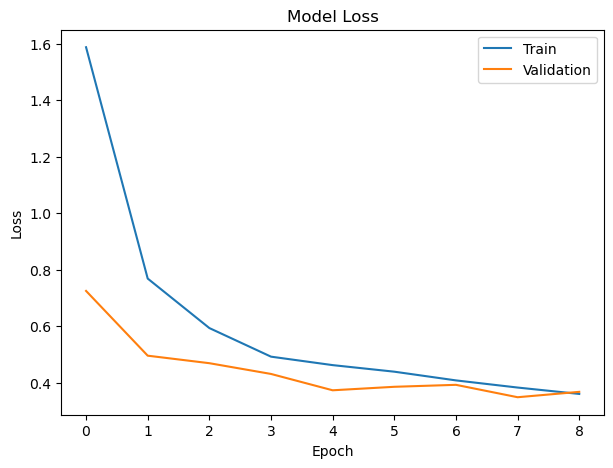

In [52]:
# Plot Model Loss graph
plot_graph(history,'loss')

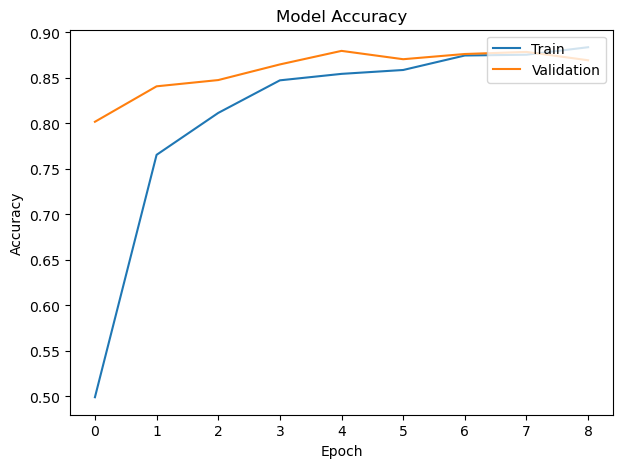

In [53]:
# Plot Model Accuracy graph
plot_graph(history,'accuracy')

In [54]:
# Evaluate Model
evalaution_metrics('CNN(ResNet152V2 - Learning Rate 0.0001)','resnet152v2L0_0001.h5' )

The accuracy of the CNN(ResNet152V2 - Learning Rate 0.0001) model is 0.8625
The loss of the CNN(ResNet152V2 - Learning Rate 0.0001) model is 0.4013


### Q - Test the best Transfer learning - CNN Model and evaluate afterwards

In [55]:
# Load and preprocess your test dataset
test_dataset = test_data_generator.flow_from_directory(
    test_path,
    target_size= (256,256),
    batch_size=64,
    class_mode='categorical',  # Assuming it's a multi-class classification task
    shuffle=False  # To maintain order for predictions
)

Found 1103 images belonging to 12 classes.


In [56]:
# Initialize a ResNet152V2 model for transfer learning with specific settings:
model = ResNet152V2(input_shape=(256,256, 3),pooling='avg',weights = 'imagenet',include_top=False)

# Using model functions created earlier:
model = create_model_arch(model)

# Load pre-trained weights for your custom model (if applicable)
# custom_model.load_weights('path_to_pretrained_weights')
# Compile the model if needed (define loss and optimizer)
model.load_weights('resnet152_model.h5')
model = compile_model(model,0.001)

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_8[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 130, 130, 64)         0         ['conv1_conv[0][0]']          
                                                                                            

 tchNormalization)                                                                                
                                                                                                  
 conv2_block3_preact_relu (  (None, 64, 64, 256)          0         ['conv2_block3_preact_bn[0][0]
 Activation)                                                        ']                            
                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 64, 64, 64)           16384     ['conv2_block3_preact_relu[0][
 D)                                                                 0]']                          
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 64, 64, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
          

 conv3_block2_1_relu (Activ  (None, 32, 32, 128)          0         ['conv3_block2_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block2_2_pad (ZeroPa  (None, 34, 34, 128)          0         ['conv3_block2_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv3_block2_2_conv (Conv2  (None, 32, 32, 128)          147456    ['conv3_block2_2_pad[0][0]']  
 D)                                                                                               
                                                                                                  
 conv3_block2_2_bn (BatchNo  (None, 32, 32, 128)          512       ['conv3_block2_2_conv[0][0]'] 
 rmalizati

                                                                                                  
 conv3_block4_out (Add)      (None, 32, 32, 512)          0         ['conv3_block3_out[0][0]',    
                                                                     'conv3_block4_3_conv[0][0]'] 
                                                                                                  
 conv3_block5_preact_bn (Ba  (None, 32, 32, 512)          2048      ['conv3_block4_out[0][0]']    
 tchNormalization)                                                                                
                                                                                                  
 conv3_block5_preact_relu (  (None, 32, 32, 512)          0         ['conv3_block5_preact_bn[0][0]
 Activation)                                                        ']                            
                                                                                                  
 conv3_blo

 ation)                                                                                           
                                                                                                  
 conv3_block7_2_pad (ZeroPa  (None, 34, 34, 128)          0         ['conv3_block7_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv3_block7_2_conv (Conv2  (None, 32, 32, 128)          147456    ['conv3_block7_2_pad[0][0]']  
 D)                                                                                               
                                                                                                  
 conv3_block7_2_bn (BatchNo  (None, 32, 32, 128)          512       ['conv3_block7_2_conv[0][0]'] 
 rmalization)                                                                                     
          

 conv4_block1_0_conv (Conv2  (None, 16, 16, 1024)         525312    ['conv4_block1_preact_relu[0][
 D)                                                                 0]']                          
                                                                                                  
 conv4_block1_3_conv (Conv2  (None, 16, 16, 1024)         263168    ['conv4_block1_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_out (Add)      (None, 16, 16, 1024)         0         ['conv4_block1_0_conv[0][0]', 
                                                                     'conv4_block1_3_conv[0][0]'] 
                                                                                                  
 conv4_block2_preact_bn (Ba  (None, 16, 16, 1024)         4096      ['conv4_block1_out[0][0]']    
 tchNormal

                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 16, 16, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block4_1_relu (Activ  (None, 16, 16, 256)          0         ['conv4_block4_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block4_2_pad (ZeroPa  (None, 18, 18, 256)          0         ['conv4_block4_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv4_blo

 ation)                                                                                           
                                                                                                  
 conv4_block6_3_conv (Conv2  (None, 16, 16, 1024)         263168    ['conv4_block6_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block6_out (Add)      (None, 16, 16, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_conv[0][0]'] 
                                                                                                  
 conv4_block7_preact_bn (Ba  (None, 16, 16, 1024)         4096      ['conv4_block6_out[0][0]']    
 tchNormalization)                                                                                
          

 conv4_block9_1_bn (BatchNo  (None, 16, 16, 256)          1024      ['conv4_block9_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block9_1_relu (Activ  (None, 16, 16, 256)          0         ['conv4_block9_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block9_2_pad (ZeroPa  (None, 18, 18, 256)          0         ['conv4_block9_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv4_block9_2_conv (Conv2  (None, 16, 16, 256)          589824    ['conv4_block9_2_pad[0][0]']  
 D)       

                                                                                                  
 conv4_block11_3_conv (Conv  (None, 16, 16, 1024)         263168    ['conv4_block11_2_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block11_out (Add)     (None, 16, 16, 1024)         0         ['conv4_block10_out[0][0]',   
                                                                     'conv4_block11_3_conv[0][0]']
                                                                                                  
 conv4_block12_preact_bn (B  (None, 16, 16, 1024)         4096      ['conv4_block11_out[0][0]']   
 atchNormalization)                                                                               
                                                                                                  
 conv4_blo

 ormalization)                                                                                    
                                                                                                  
 conv4_block14_1_relu (Acti  (None, 16, 16, 256)          0         ['conv4_block14_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block14_2_pad (ZeroP  (None, 18, 18, 256)          0         ['conv4_block14_1_relu[0][0]']
 adding2D)                                                                                        
                                                                                                  
 conv4_block14_2_conv (Conv  (None, 16, 16, 256)          589824    ['conv4_block14_2_pad[0][0]'] 
 2D)                                                                                              
          

 conv4_block16_3_conv (Conv  (None, 16, 16, 1024)         263168    ['conv4_block16_2_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block16_out (Add)     (None, 16, 16, 1024)         0         ['conv4_block15_out[0][0]',   
                                                                     'conv4_block16_3_conv[0][0]']
                                                                                                  
 conv4_block17_preact_bn (B  (None, 16, 16, 1024)         4096      ['conv4_block16_out[0][0]']   
 atchNormalization)                                                                               
                                                                                                  
 conv4_block17_preact_relu   (None, 16, 16, 1024)         0         ['conv4_block17_preact_bn[0][0
 (Activati

                                                                                                  
 conv4_block19_1_relu (Acti  (None, 16, 16, 256)          0         ['conv4_block19_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block19_2_pad (ZeroP  (None, 18, 18, 256)          0         ['conv4_block19_1_relu[0][0]']
 adding2D)                                                                                        
                                                                                                  
 conv4_block19_2_conv (Conv  (None, 16, 16, 256)          589824    ['conv4_block19_2_pad[0][0]'] 
 2D)                                                                                              
                                                                                                  
 conv4_blo

 2D)                                                                                              
                                                                                                  
 conv4_block21_out (Add)     (None, 16, 16, 1024)         0         ['conv4_block20_out[0][0]',   
                                                                     'conv4_block21_3_conv[0][0]']
                                                                                                  
 conv4_block22_preact_bn (B  (None, 16, 16, 1024)         4096      ['conv4_block21_out[0][0]']   
 atchNormalization)                                                                               
                                                                                                  
 conv4_block22_preact_relu   (None, 16, 16, 1024)         0         ['conv4_block22_preact_bn[0][0
 (Activation)                                                       ]']                           
          

 conv4_block24_1_relu (Acti  (None, 16, 16, 256)          0         ['conv4_block24_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block24_2_pad (ZeroP  (None, 18, 18, 256)          0         ['conv4_block24_1_relu[0][0]']
 adding2D)                                                                                        
                                                                                                  
 conv4_block24_2_conv (Conv  (None, 16, 16, 256)          589824    ['conv4_block24_2_pad[0][0]'] 
 2D)                                                                                              
                                                                                                  
 conv4_block24_2_bn (BatchN  (None, 16, 16, 256)          1024      ['conv4_block24_2_conv[0][0]']
 ormalizat

                                                                                                  
 conv4_block26_out (Add)     (None, 16, 16, 1024)         0         ['conv4_block25_out[0][0]',   
                                                                     'conv4_block26_3_conv[0][0]']
                                                                                                  
 conv4_block27_preact_bn (B  (None, 16, 16, 1024)         4096      ['conv4_block26_out[0][0]']   
 atchNormalization)                                                                               
                                                                                                  
 conv4_block27_preact_relu   (None, 16, 16, 1024)         0         ['conv4_block27_preact_bn[0][0
 (Activation)                                                       ]']                           
                                                                                                  
 conv4_blo

 vation)                                                                                          
                                                                                                  
 conv4_block29_2_pad (ZeroP  (None, 18, 18, 256)          0         ['conv4_block29_1_relu[0][0]']
 adding2D)                                                                                        
                                                                                                  
 conv4_block29_2_conv (Conv  (None, 16, 16, 256)          589824    ['conv4_block29_2_pad[0][0]'] 
 2D)                                                                                              
                                                                                                  
 conv4_block29_2_bn (BatchN  (None, 16, 16, 256)          1024      ['conv4_block29_2_conv[0][0]']
 ormalization)                                                                                    
          

 conv4_block31_out (Add)     (None, 16, 16, 1024)         0         ['conv4_block30_out[0][0]',   
                                                                     'conv4_block31_3_conv[0][0]']
                                                                                                  
 conv4_block32_preact_bn (B  (None, 16, 16, 1024)         4096      ['conv4_block31_out[0][0]']   
 atchNormalization)                                                                               
                                                                                                  
 conv4_block32_preact_relu   (None, 16, 16, 1024)         0         ['conv4_block32_preact_bn[0][0
 (Activation)                                                       ]']                           
                                                                                                  
 conv4_block32_1_conv (Conv  (None, 16, 16, 256)          262144    ['conv4_block32_preact_relu[0]
 2D)      

                                                                                                  
 conv4_block34_2_pad (ZeroP  (None, 18, 18, 256)          0         ['conv4_block34_1_relu[0][0]']
 adding2D)                                                                                        
                                                                                                  
 conv4_block34_2_conv (Conv  (None, 16, 16, 256)          589824    ['conv4_block34_2_pad[0][0]'] 
 2D)                                                                                              
                                                                                                  
 conv4_block34_2_bn (BatchN  (None, 16, 16, 256)          1024      ['conv4_block34_2_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_blo

 2D)                                                                                              
                                                                                                  
 conv4_block36_out (Add)     (None, 8, 8, 1024)           0         ['max_pooling2d_21[0][0]',    
                                                                     'conv4_block36_3_conv[0][0]']
                                                                                                  
 conv5_block1_preact_bn (Ba  (None, 8, 8, 1024)           4096      ['conv4_block36_out[0][0]']   
 tchNormalization)                                                                                
                                                                                                  
 conv5_block1_preact_relu (  (None, 8, 8, 1024)           0         ['conv5_block1_preact_bn[0][0]
 Activation)                                                        ']                            
          

 conv5_block3_1_bn (BatchNo  (None, 8, 8, 512)            2048      ['conv5_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_1_relu (Activ  (None, 8, 8, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_pad (ZeroPa  (None, 10, 10, 512)          0         ['conv5_block3_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 8, 8, 512)            2359296   ['conv5_block3_2_pad[0][0]']  
 D)       

In [57]:
# Make predictions on the test dataset
predictions = model.predict(test_dataset, verbose=0)

# Get predicted labels and true labels
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_dataset.classes

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"The Model(ResNet152V2) is was tested and achieved the accuracy of: {accuracy:.4f}")


The Model(ResNet152V2) is was tested and achieved the accuracy of: 0.8821


In [58]:
# Calculate classification report
report = classification_report(true_labels, predicted_labels, target_names=pest_class)

# Print the classification report table
print("Classification Report:")
print("=========================")
print(" ")
print(report)

Classification Report:
 
              precision    recall  f1-score   support

        ants       0.92      0.97      0.95       100
        bees       0.88      0.98      0.92       100
      beetle       0.88      0.55      0.68        84
catterpillar       0.70      0.85      0.77        87
  earthworms       0.86      0.85      0.85        65
      earwig       0.78      0.72      0.75        94
 grasshopper       0.88      0.90      0.89        97
        moth       0.96      1.00      0.98       100
        slug       0.89      0.75      0.81        79
       snail       0.95      1.00      0.98       100
        wasp       0.93      0.95      0.94       100
      weevil       0.92      0.97      0.94        97

    accuracy                           0.88      1103
   macro avg       0.88      0.87      0.87      1103
weighted avg       0.88      0.88      0.88      1103



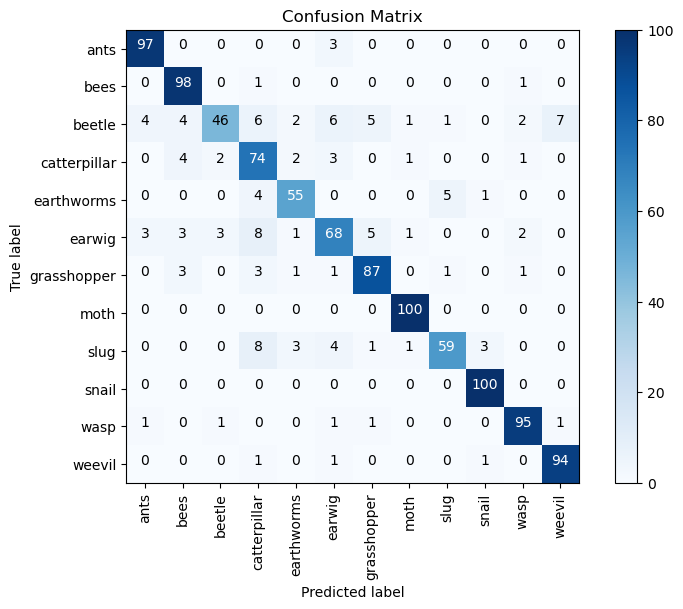

In [59]:
# Generate a confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Define a function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    # Plot the matrix using imshow
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    # Define tick marks for the class labels on x and y axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    # Add text annotations to each cell of the matrix
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    # Label the axes and ensure tight layout
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Define the class names for labeling the matrix

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm, classes=pest_class, title='Confusion Matrix')
plt.show()